# **Chap8：图神经网络GNN**

In [1]:
import tensorflow as tf
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from abc import abstractmethod
from rdkit import Chem
from source.code import ch8
from source.code import utils 
import os
import time

2023-07-18 15:05:07.839096: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-18 15:05:07.981268: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-18 15:05:08.020891: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-07-18 15:05:08.787613: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [2]:
# 如果你要在服务器上和别人共用GPU，可以设置你需要的显存资源
utils.gpu_limitation_config(memory=30,device=2)

## **8.3 信息传递MP（Message Passing）**

### **8.3.1 GN Block**

我们在 **8.1节** 中介绍了 GNN 计算过程中信息传递（**Message Passing**，简称**MP**）的概念，在 **8.2节** 中实现了几个最简单的 GNN 模型，它们在计算过程中都**只考虑了节点特征**，而**忽略了边特征和全图特征**，并且**信息传递时仅汇聚了来自邻居节点的特征**，本节我们介绍**一般的 GNN 信息传递的计算框架**，并尝试用该框架实现更复杂的图预测任务

我们把具有一般性消息传递机制的 GNN 计算层称为一个 **GN Block**（Graph Neraul Network Block）或者 **GN Layer**，这些 GNN 模块均以图作为输入，并输出图（**Graph-in，Graph-out**），因此，我们能够像使用全连接神经网络一样，将多个 GN BLock 进行堆叠，形成多层的 GNN 模型
* 回忆在前面章节中我们介绍过，**GNN 模型消息传递的距离（即消息传递的跳数）等于 GNN 层的数量** `num_layers`

我们首先定义一些图相关的表示（**为了记号简单，下面所有特征维度的表示都是 $p$，但节点、边、全图特征的维度是可以不同的**），在一个标准的 GN Block 中：
* 用 $G=\{V,E,\mathbf{u}\}$ 表示图，其中 $V$ 表示节点集合，$|V| = N_v$，$E$ 表示边集合，$|E|=N_e$，$\mathbf{u}\in\mathbb{R}^p$ **是代表全图特征的向量**
* 用 $\mathbf{v}_i\in\mathbb{R}^p, i\in V$ 表示**节点特征向量**，$\mathbf{e}_{s,r}\in\mathbb{R}^p, (s,r)\in E$ 表示**边特征向量**
* $\phi_e, \phi_v, \phi_u$ 是三个分别**用于更新边特征表示、节点特征表示、全图特征表示的映射**
* 我们还有**三个消息传递汇聚函数** $\rho$：
  * $\rho_{E\to V}$：对每个节点而言，负责将与节点相连接的边的信息汇聚到节点，用于更新 $\mathbf{v}_i$
  * $\rho_{E\to U}$：负责将全图所有的边信息进行汇聚，用于更新 $\mathbf{u}$
  * $\rho_{V\to U}$：负责将全图所有的节点信息进行汇聚，用于更新 $\mathbf{u}$

一个 **GN Block 的计算逻辑如下图所示**

<img src="../source/Chap8/GNBlock.png" width=800>

GN Block 的计算过程详细介绍如下：
* **STEP 1：更新边特征，对应 $\phi_e$**
  * 对每一条边 $(s,r)\in E$，其特征为 $\mathbf{e}_{s,r}$，$s,r$ 分别表示该边两端的出、入节点索引，$\mathbf{v}_s,\mathbf{v}_r$ 是对应的节点特征
  * 结合全图特征 $\mathbf{u}$，**更新边特征** $\mathbf{e}_{s,r}^{\prime} = \phi_e(\mathbf{e}_{s,r},\mathbf{v}_s,\mathbf{v}_r,\mathbf{u})$
  * 注意，**这里函数 $\phi_e$ 参数共享**，即图中所有边在执行更新操作时，$\phi_e$ 使用同一套参数
* **STEP 2：汇聚边特征到节点，对应 $\rho_{E\to V}$**
  * 用 $E_i = \{\mathbf{e}_{s,i}^{\prime},(s,i)\in E\},i\in V$ **表示节点 $i$ 相连接的边特征集合**，并且这里的**边特征 $e_{s,i}^{\prime}$ 是已经更新后的**
  * **边特征聚合函数 $\rho_{E\to V}$ 以 $E_i$ 为输入**，通过聚合（例如最大、最小、平均等）得到特征 $\mathbf{e}_i^{\prime}$，即 $\mathbf{e}_i^{\prime} = \rho_{E\to V}(E_i),i\in V$
  * 按照 GNN 的思想，$\rho_{E\to V}$ **需要具有置换不变性**
* **STEP 3：更新节点特征，对应 $\phi_v$**
  * 对每个节点 $i\in V$，其特征为 $\mathbf{v}_i$
  * 结合全图特征 $\mathbf{u}$，以及从邻居边上汇聚得到的特征 $\mathbf{e}_i^{\prime}$，**更新节点** $\mathbf{v}_{i}^{\prime} = \phi_v(\mathbf{e}_{i}^{\prime},\mathbf{v}_i,\mathbf{u})$
  * 注意，**这里函数 $\phi_v$ 参数共享**，即图中所有节点在执行更新操作时，$\phi_v$ 使用同一套参数
* **STEP 4：汇聚边特征到全图，对应 $\rho_{E\to U}$**
  * 继续**沿用 STEP 2 中的** $E_i = \{\mathbf{e}_{s,i}^{\prime},(s,i)\in E\},i\in V$，现在记 $E^{\prime} = \bigcup_i E_i = \{\mathbf{e}_{s,r}^{\prime},(s,r)\in E\}$ **表示所有更新后的边特征集合**
  * **聚合函数 $\rho_{E\to U}$ 以 $E^{\prime}$ 为输入**，通过聚合得到特征 $\mathbf{e}^{\prime}$，即 $\mathbf{e}^{\prime} = \rho_{E\to U}(E^{\prime})$
  * 按照 GNN 的思想，$\rho_{E\to U}$ **需要具有置换不变性**
* **STEP 5：汇聚节点特征到全图，对应 $\rho_{V\to U}$**：
  * 记 $V^{\prime} = \{\mathbf{v}_{i}^{\prime},i\in V\}$ **表示所有更新后的节点特征集合**
  * **聚合函数 $\rho_{V\to U}$ 以 $V^{\prime}$ 为输入**，通过聚合得到特征 $\mathbf{v}^{\prime}$，即 $\mathbf{v}^{\prime} = \rho_{V\to U}(V^{\prime})$
  * 按照 GNN 的思想，$\rho_{V\to U}$ **需要具有置换不变性**
* **STEP 6：更新全图特征，对应 $\phi_u$**
  * 全图特征为 $\mathbf{u}$，结合聚合特征 $\mathbf{v}^{\prime},\mathbf{e}^{\prime}$，**更新特征** $\mathbf{u}^{\prime} = \phi_u(\mathbf{e}^{\prime},\mathbf{v}^{\prime},\mathbf{u})$

我们对 GN Block 的**消息传递的选择**，以及**更新函数 $\phi_e,\phi_v,\phi_u$ 的选择做进一步说明**

**(1) 消息传递的选择**

上述我们介绍的是一个完整的 GN Block 计算流程，通过 6 个步骤，节点、边和全图信息进行了充分交互，但**在实践中，GN Block 中的消息传递步骤不一定都要进行**
* 有时候，我们可能会**因为缺少边特征、缺少全图特征而省去部分消息传递步骤**
* 或者**根据任务需求和专家经验**，我们**可能认为部分消息传递步骤是不必要的**，那么就可以在 GN Block 的计算过程中移除它们

因此，在 GN Block 统一框架的实现中，我们可以**设置三个布尔参数** `edge_mp`, `node_mp`, `global_mp` **来控制是否开启边、节点、全图的消息传递**
* 例如，如果 `edge_mp = False` **去掉边消息的传递**，则 GN Block 发生的主要变化是：
  * 边特征汇聚过程 $\rho_{E\to V},\rho_{E\to U}$ 不需要进行
  * $\phi_v(\mathbf{e}_{i}^{\prime},\mathbf{v}_i,\mathbf{u}) \to \phi_v(\mathbf{v}_i,\mathbf{u})$
  * $\phi_u(\mathbf{e}^{\prime},\mathbf{v}^{\prime},\mathbf{u}) \to \phi_u(\mathbf{v}^{\prime},\mathbf{u})$
* 而如果三个参数 `edge_mp = node_mp = global_mp = False`，**关闭所有的消息传递**，则：
  * 特征汇聚过程 $\rho_{E\to V},\rho_{E\to U},\rho_{V\to U}$ 都不需要进行
  * $\phi_e(\mathbf{e}_{s,r},\mathbf{v}_s,\mathbf{v}_r,\mathbf{u}) = \phi_e(\mathbf{e}_{s,r})$
  * $\phi_v(\mathbf{e}_{i}^{\prime},\mathbf{v}_i,\mathbf{u}) \to \phi_v(\mathbf{v}_i)$
  * $\phi_u(\mathbf{e}^{\prime},\mathbf{v}^{\prime},\mathbf{u}) \to \phi_u(\mathbf{u})$
  * 此时**边、节点和全图的特征独立更新，相当于 GN Block 没有使用任何图结构信息**

**(2) 更新函数 $\phi_e,\phi_v,\phi_u$ 的选择**

对于神经网络而言，**更新函数 $\phi$ 的形式、类别选择非常灵活**，任何合理的设计都可以使用，但也有一些基本的设计思想和规则

* **最基本的设计，使用 MLP**
  * 最简单的想法，是**将输入给 $\phi$ 的多个特征在特征维度上拼接在一起**，然后作为 MLP 的输入，例如：
      $$ \phi_e(\mathbf{e}_{s,r},\mathbf{v}_s,\mathbf{v}_r,\mathbf{u}) = f(\text{concat}[\mathbf{e}_{s,r};\mathbf{v}_s;\mathbf{v}_r;\mathbf{u}]) $$
  * 类似缩放点积注意力，可以**巧用内积，来减少模型的参数量**，例如在边特征更新时，可以考虑：
      $$ \phi_e(\mathbf{e}_{s,r},\mathbf{v}_s,\mathbf{v}_r,\mathbf{u}) = f_e(\mathbf{e}_{s,r}) + \frac{\mathbf{v}_s^T\mathbf{v}_r}{\sqrt{q}} + f_u(\mathbf{u}) $$

* **根据特征类型变换网络结构**
  * 通常来说，特征是一个一维向量，此时使用 MLP 是合适的
  * 如果每个**节点存储的特征是图像或其它二维张量**，那么或许将更新函数更换为 CNN 模型会更加合适
  * 如果**节点、边上存储的特征具有序列属性**，那么 RNN 和 Attention 作为 $\phi$ 的骨干模型会更加合适

* **使用深度学习的基本技巧**
  * 一些基本的模型结构也可以设计到 $\phi$ 中，**例如 Dropout，BatchNorm，LayerNorm**
  * 尝试使用**残差跳连**，将更新过程从 $\phi(x)$ 变为 $x + \phi(x)$，能获得残差结构的很多优势

下面我们来实现 `GNBlock`，**为了将 GN Block 的实现逻辑做进一步抽象，我们先定义 `GNBlockBase` 作为基类，它提供执行 GN Block 计算的函数接口**
* 后续的模型的实现只需要**继承该基类**，**重新定义三个更新函数** $\phi_e,\phi_v,\phi_u$ 和**三个信息汇聚函数** $\rho_{E\to V},\rho_{E\to U},\rho_{V\to U}$
* 我们**用 `@abstractmethod` 装饰器包装了函数** $\phi_e,\phi_v,\phi_u$ 和 $\rho_{E\to V},\rho_{E\to U},\rho_{V\to U}$，因此**基类 `GNBlockBase` 无法实例化**，必须继承 `GNBlockBase` 并重写这几个方法的实现
* 我们在 `call()` 方法中定义好了计算逻辑，**对于继承自 `GBBlockBase` 的其它子类，通常情况下就无需再定义 `call()` 方法中的推理逻辑了，因为它们是一样的**

In [3]:
class GNBlockBase(tf.keras.layers.Layer):
    def __init__(self, node_mp : bool=True, edge_mp : bool=True, global_mp : bool=True, **kwargs):
        """
        Parameters
        ----------
        node_mp : bool, default = `True`
            是否开启节点消息传递
        edge_mp : bool, default = `True`
            是否开启边消息传递
        global_mp : bool, default = `True`
            是否开启全局消息传递
        """
        super(GNBlockBase, self).__init__(**kwargs)
        # 是否开启消息传递 Message Passing
        self.node_mp, self.edge_mp, self.global_mp = node_mp, edge_mp, global_mp
    
    # 边更新函数
    @abstractmethod
    def phi_edge(self, edges_feat : tf.Tensor=None, 
                 vertex_feat_s : tf.Tensor=None, 
                 vertex_feat_r : tf.Tensor=None, 
                 global_feat : tf.Tensor=None, **kwargs):
        raise NotImplementedError

    # 节点更新函数
    @abstractmethod
    def phi_node(self, vertex_feat : tf.Tensor=None, 
                 connected_edges_feat : tf.Tensor=None, 
                 global_feat : tf.Tensor=None, **kwargs):
        raise NotImplementedError
    
    # 全局更新函数
    @abstractmethod
    def phi_global(self, global_feat : tf.Tensor=None,
                   agg_vertex_feat : tf.Tensor=None, 
                   agg_edges_feat : tf.Tensor=None, **kwargs):
        raise NotImplementedError
    
    # 边到节点的汇聚函数
    @abstractmethod
    def rho_edge_to_node(self, graph : dict, **kwargs):
        raise NotImplementedError

    # 边到全图特征的汇聚函数
    @abstractmethod
    def rho_edge_to_global(self, graph : dict, **kwargs):
        raise NotImplementedError
    
    # 节点到全图特征的汇聚函数
    @abstractmethod
    def rho_node_to_global(self, graph : dict, **kwargs):
        raise NotImplementedError

    # GN Block 的前向推理逻辑
    def call(self, graph, **kwargs):
        """
        graph 是包含图信息的字典，包含 `vertex_feat`, `edges_feat`, `edges_idx`, `neighbors_idx`
        `connected_edges_idx`, `valid_lens`, `valid_nodes`, `valid_edges`, `global_feat`\n

        每种图信息的第一个维度都是批量维度 `batch_size`，即图的数量 `num_graph = batch_size`\n
        对于节点相关的信息，第二个维度是节点数量 `num_nodes`\n
        对于边相关的信息，第二个维度是边数量 `num_edges`\n
        """
        
        # STEP 1: 边特征更新，对应 phi_e
        if self.node_mp:
            vertex_feat_s = tf.gather(graph['vertex_feat'], graph['edges_idx'][:,:,0], batch_dims=1)
            vertex_feat_r = tf.gather(graph['vertex_feat'], graph['edges_idx'][:,:,1], batch_dims=1)
        else:
            vertex_feat_s = vertex_feat_r = None
        global_feat = graph['global_feat'] if self.global_mp else None
        graph["edges_feat"] = self.phi_edge(graph["edges_feat"], vertex_feat_s, vertex_feat_r, global_feat)

        # STEP 2: 汇聚边特征到节点，对应 rho_{E->V}
        # 这里不定义汇聚逻辑，汇聚逻辑在 rho_edge_to_node 中定义
        connected_edges_feat = self.rho_edge_to_node(graph) if self.edge_mp else None
        
        # STEP 3: 节点特征更新，对应 phi_v
        global_feat = graph['global_feat'] if self.global_mp else None
        graph["vertex_feat"] = self.phi_node(graph["vertex_feat"], connected_edges_feat, global_feat)

        # STEP 4: 汇聚边特征到全图，对应 rho_{E->U}
        agg_edges_feat = self.rho_edge_to_global(graph) if self.edge_mp else None
        # STEP 5: 汇聚节点特征到全图，对应 rho_{V->U}
        agg_vertex_feat = self.rho_node_to_global(graph) if self.node_mp else None

        # STEP 6: 全图特征更新，对应 phi_u
        graph["global_feat"] = self.phi_global(graph["global_feat"], agg_vertex_feat, agg_edges_feat)

        return graph

接下来我们**继承 `GNBlockBase` 重写类的 6 个函数**，来完成一种简单的 GN Block 实现
* **边特征更新逻辑**：$\phi_e(\mathbf{e}_{s,r},\mathbf{v}_s,\mathbf{v}_r,\mathbf{u})$
    $$
    \phi_e(\mathbf{e}_{s,r},\mathbf{v}_s,\mathbf{v}_r,\mathbf{u}) = \text{LayerNorm}\left(\text{Residual}\left(\text{MLP}\left( \text{concat}[\mathbf{e}_{s,r};\mathbf{v}_s;\mathbf{v}_r;\mathbf{u}] \right)\right)\right)
    $$
    注意：如果缺失对应的特征，则在 `MLP` 层中去掉对应的输入特征，**如果图不需要有边特征，则取消边特征更新的计算，直接返回 `None`**
* **边特征汇聚到节点**：$\rho_{E\to V}(E_i)$：
    $$
    \rho_{E\to V}(E_i) = \text{mean}\left(\mathbf{e}_{s,i}, (s,i)\in E_i  \right)
    $$
    注意：计算均值时需要除以有效邻居节点个数 `valid_lens`，**对于没有邻居的孤立节点 `valid_lens = 0` 需要让 `valid_lens = 1` 防止除以 0**
* **节点特征更新逻辑**：$\phi_v(\mathbf{e}_i^{\prime},\mathbf{v}_i,\mathbf{u})$
    $$
    \phi_v(\mathbf{e}_i^{\prime},\mathbf{v}_i,\mathbf{u}) = \text{LayerNorm}\left(\text{Residual}\left(\text{MLP}\left( \text{concat}[\mathbf{e}_i^{\prime},\mathbf{v}_i,\mathbf{u}] \right)\right)\right)
    $$
    注意：如果缺失对应的特征，则在 `MLP` 层中去掉对应的输入特征，**如果图不需要有节点特征，则取消节点特征更新的计算，直接返回 `None`**
* **边特征汇聚到全图**：$\rho_{E\to U}(E^{\prime})$：
    $$
    \rho_{E\to U}(E^{\prime}) = \text{mean}\left(\mathbf{e}_{s,r}, (s,r)\in E  \right)
    $$
    注意：**计算均值时需要除以有效边个数 `valid_edges`**
* **节点特征汇聚到全图**：$\rho_{V\to U}(V^{\prime})$：
    $$
    \rho_{V\to U}(V^{\prime}) = \text{mean}\left(\mathbf{v}_{i}, i\in V  \right)
    $$
    注意：**计算均值时需要除以有效结点个数 `valid_nodes`**
* **全图特征更新逻辑**：$\phi_u(\mathbf{e}^{\prime},\mathbf{v}^{\prime},\mathbf{u})$
    $$
    \phi_u(\mathbf{e}^{\prime},\mathbf{v}^{\prime},\mathbf{u}) = \text{BatchNorm}\left(\text{Residual}\left(\text{MLP}\left( \text{concat}[\mathbf{e}^{\prime},\mathbf{v}^{\prime},\mathbf{u}] \right)\right)\right)
    $$

注意到，我们在**边特征更新、节点特征更新和全图特征更新中使用了 `LayerNorm` 或 `BatchNorm`，以及残差连接 `Residual`，这能一定程度上增加模型数值稳定性，加速模型收敛**
* 由于每个批量的图数据中，节点数量和边数量会发生变化，回忆 `Transformer`，这种张量形状会改变的情况使用 `LayerNorm` 会更合适

类 `GNBlock` 按照上述逻辑实现了一个完整的 GN Block 模型

In [86]:
class GNBlock(GNBlockBase):
    def __init__(self, edge_num_hiddens : int, node_num_hiddens : int, global_num_hiddens : int, dropout : float=0.25,
                 node_mp: bool = True, edge_mp: bool = True, global_mp: bool = True, **kwargs):
        super(GNBlock, self).__init__(node_mp, edge_mp, global_mp, **kwargs)
        # 边特征更新的 MLP + LayerNorm
        self.phi_edge_mlp = tf.keras.Sequential([
            tf.keras.layers.Dense(edge_num_hiddens, activation="relu"),
            tf.keras.layers.Dropout(dropout)
        ])
        self.phi_edge_ln = tf.keras.layers.LayerNormalization()
        # 节点特征更新的 MLP + LayerNorm
        self.phi_node_mlp = tf.keras.Sequential([
            tf.keras.layers.Dense(node_num_hiddens, activation="relu"),
            tf.keras.layers.Dropout(dropout)
        ])
        self.phi_node_ln = tf.keras.layers.LayerNormalization()
        # 全图特征更新的 MLP + BatchNorm
        self.phi_global_mlp = tf.keras.Sequential([
            tf.keras.layers.Dense(global_num_hiddens, activation="relu"),
            tf.keras.layers.Dropout(dropout)
        ])
        self.phi_global_bn = tf.keras.layers.BatchNormalization()
    
    def phi_edge(self, edges_feat : tf.Tensor=None,
                 vertex_feat_s : tf.Tensor=None,
                 vertex_feat_r : tf.Tensor=None,
                 global_feat : tf.Tensor=None, **kwargs):
        # edges_feat, vertex_feat_s, vertex_feat_r : (num_graph, num_edges, num_feat)
        # global_feat : (num_graph, num_feat)
        if edges_feat is None:
            return None
        
        # 如果要使用 global_feat，需要先扩展维度
        if global_feat is not None:
            global_feat = tf.expand_dims(global_feat, axis=1) # (num_graph, 1, num_feat)
            global_feat = tf.tile(global_feat, [1, tf.shape(edges_feat)[1], 1]) # (num_graph, num_edges, num_feat)
        
        # 组装输入特征，去掉 None 的特征
        inputs = [edges_feat, vertex_feat_s, vertex_feat_r, global_feat]
        inputs = [x for x in inputs if x is not None]
        # 拼接输入特征
        inputs = tf.concat(inputs, axis=-1)

        # MLP 变换 + LayerNorm + 残差连接
        mlp_output = self.phi_edge_mlp(inputs, **kwargs)
        updated_edges_feat = self.phi_edge_ln(mlp_output + edges_feat, **kwargs)
        return updated_edges_feat
    
    def phi_node(self, vertex_feat : tf.Tensor=None,
                 connected_edges_feat : tf.Tensor=None,
                 global_feat : tf.Tensor=None, **kwargs):
        # vertex_feat, connected_edges_feat : (num_graph, num_nodes, num_feat)
        # global_feat : (num_graph, num_feat)
        if vertex_feat is None:
            return None
        
        # 如果要使用 global_feat，需要先扩展维度
        if global_feat is not None:
            global_feat = tf.expand_dims(global_feat, axis=1) # (num_graph, 1, num_feat)
            global_feat = tf.tile(global_feat, [1, tf.shape(vertex_feat)[1], 1]) # (num_graph, num_nodes, num_feat)
        
        # 组装输入特征，去掉 None 的特征
        inputs = [vertex_feat, connected_edges_feat, global_feat]
        inputs = [x for x in inputs if x is not None]
        # 拼接输入特征
        inputs = tf.concat(inputs, axis=-1)

        # MLP 变换 + LayerNorm + 残差连接
        mlp_output = self.phi_node_mlp(inputs, **kwargs)
        updated_vertex_feat = self.phi_node_ln(mlp_output + vertex_feat, **kwargs)
        return updated_vertex_feat
    
    def phi_global(self, global_feat : tf.Tensor=None,
                   agg_vertex_feat : tf.Tensor=None,
                   agg_edges_feat : tf.Tensor=None, **kwargs):
        # global_feat, agg_vertex_feat, agg_edges_feat : (num_graph, num_feat)
        if global_feat is None:
            return None
        
        # 组装输入特征，去掉 None 的特征
        inputs = [global_feat, agg_vertex_feat, agg_edges_feat]
        inputs = [x for x in inputs if x is not None]
        # 拼接输入特征
        inputs = tf.concat(inputs, axis=-1)

        # MLP 变换 + BatchNorm + 残差连接
        mlp_output = self.phi_global_mlp(inputs, **kwargs)
        updated_global_feat = self.phi_global_bn(mlp_output + global_feat, **kwargs)
        return updated_global_feat
    
    def rho_edge_to_node(self, graph : dict, **kwargs):
        # 没有边特征，不需要汇聚
        if graph['edges_feat'] is None:
            return None
        # 获取连接的边特征，形状 : (num_graph, num_nodes, num_neighbors, num_feat)
        connected_edges_feat = tf.gather(graph['edges_feat'], graph['connected_edges_idx'], batch_dims=1)
        valid_lens = tf.cast(graph['valid_lens'], tf.float32) # (num_graph, num_nodes)
        valid_lens = tf.where(tf.equal(valid_lens, 0), tf.ones_like(valid_lens), valid_lens) # 避免除以 0
        
        # 汇聚均值，形状 : (num_graph, num_nodes, num_feat)
        # valid_lens 扩展一个维度，便于广播
        connected_edges_feat = tf.reduce_sum(connected_edges_feat, axis=2) / tf.expand_dims(valid_lens, axis=-1)

        return connected_edges_feat
    
    def rho_edge_to_global(self, graph : dict, **kwargs):
        # 没有边特征，不需要汇聚
        if graph['edges_feat'] is None:
            return None
        # 获取边特征，形状 : (num_graph, num_edges, num_feat)
        edges_feat = graph['edges_feat']
        # 有效边的数量，形状 : (num_graph, )
        valid_edges = tf.cast(graph['valid_edges'], tf.float32)
        valid_edges = tf.where(tf.equal(valid_edges, 0), tf.ones_like(valid_edges), valid_edges) # 避免除以 0

        # 汇聚均值，形状 : (num_graph, num_feat)
        # valid_edges 扩展一个维度，便于广播
        agg_edges_feat = tf.reduce_sum(edges_feat, axis=1) / tf.expand_dims(valid_edges, axis=-1)

        return agg_edges_feat

    def rho_node_to_global(self, graph : dict, **kwargs):
        # 没有节点特征，不需要汇聚
        if graph['vertex_feat'] is None:
            return None
        # 获取节点特征，形状 : (num_graph, num_nodes, num_feat)
        vertex_feat = graph['vertex_feat']
        # 有效节点的数量，形状 : (num_graph, )
        valid_nodes = tf.cast(graph['valid_nodes'], tf.float32)
        valid_nodes = tf.where(tf.equal(valid_nodes, 0), tf.ones_like(valid_nodes), valid_nodes) # 避免除以 0

        # 汇聚均值，形状 : (num_graph, num_feat)
        # valid_nodes 扩展一个维度，便于广播
        agg_vertex_feat = tf.reduce_sum(vertex_feat, axis=1) / tf.expand_dims(valid_nodes, axis=-1)

        return agg_vertex_feat

----

### **8.3.2 全图预测**

下面我们以 `LeffingWell` 分子数据集为例，通过前面定义的 GN Block 模块来**实现 GNN 全图预测任务**

**(1) 读取数据集**

`LeffingWell` 数据集**包含了 3000 多个化学分子的结构及其一些表现出来的性质**，文件存放在 `../source/data/graph/leffingwell`，目录结构如下：
* `leffingwell`
  * `molecules.csv`：化学分子数据，主要字段包含：
    * **分子索引** `CID`
    * **分子量** `MolecularWeight`
    * **国际标准分子 SMILES 表示** `IsomericSMILES`（**一个字符串，可以利用一些化学分子包，例如 `rdkit` 将其解析为化学分子结构**）
  * `behavier.csv`：分子表现出的性质
    * **分子索引** `CID`
    * 其余 **100 多个字段分别表示分子是否具有该性质**，例如 `alcoholic`，`woody`，`pungent` 等，**1 表示有，0 表示无**

我们可以读取分子数据集，查看数据格式

In [5]:
data = pd.read_csv("../source/data/graph/leffingwell/molecules.csv")
data.head(5)

,CID,MolecularWeight,IsomericSMILES,IUPACName,name,Raw Labels,Labels
0,-955348933095,240.387,CCCCC=COC(=O)CCCCCCCC,NaN,Hexenyl nonanoate,"Herbal-green, waxy, oily, fruity","['green', 'oily', 'fruity', 'waxy', 'herbal']"
1,-923209957509,196.290,CC(=O)OCC1C=CC(C(C)C)CC1,NaN,Tetrahydrocuminyl acetate,"Herbaceous, woody, slight spicy fruity odor","['woody', 'spicy', 'fruity', 'herbal']"
2,-874408321546,244.331,CCCCCCCCC(OC(C)=O)C(=O)OC,NaN,Methyl acetoxydecanoate,"delta-decalactone precursor; peach, apricot, b...","['peach', 'apricot', 'buttery']"
3,-873963935677,198.306,CCCCC=COC(=O)C(C)CCC,NaN,Hexenyl methylvalerate,"Green, fruity, apple-like","['green', 'fruity', 'apple', 'tropical']"
4,-862841422647,148.271,CCCC(S)COCC,NaN,Ethoxymethylbutanethiol,Catty urine; cassis in dilution,['catty']


在图任务中，我们关心的是分子结构特征 `SMILE`，它是一个**标准化的分子结构字符串表达式**，便于保存分子结构
* 这里数据集中的分子都是有机分子，因此**分子中的原子只包含 `C, N, O, S` 四种类型**，每个原子可以作为图中的节点
* **多余原子键位处所连接的氢原子 `H` 被省略**，因此 `SMILE` 字符串中不包含 `H`，我们**在图结构中也不需要考虑氢原子**
* 化学分子中原子之间的**化学键有四种类型，分别是：单键，双键，三键和芳香环**，化学键可以作为图中的边

下面，我们展示用 `rdkit.Chem` 来从一个 `SMILE` 字符串**解析为一个化学分子结构，并可视化该分子**
* 我们直接**将原子类型、化学键类型作为图中的节点特征和边特征**，后续我们可以**用 One-Hot 编码将这些代表类别的整数映射为 0-1 向量**

In [6]:
# 从 SMILE 字符串中解析出分子图
def decode_smile_into_graph(smile : str):
    from rdkit import Chem

    # 原子映射字典 和 化学键映射字典
    AtomMap = {"C": 0, "N": 1, "O": 2, "S": 3}
    BondMap = {"SINGLE": 0, "DOUBLE": 1, "TRIPLE": 2, "AROMATIC": 3}

    num_neighbors = 4 # 化学分子，每个节点最多有 4 个邻居

    # 将 SMILES 字符串转换为分子对象
    molecule = Chem.MolFromSmiles(smile)
    graph = Chem.RWMol(molecule) # 拷贝分子对象，用于创建分子图

    vertex = [] # 节点列表
    vertex_feat = [] # 节点特征列表
    edges = [] # 边列表

    # 获取节点信息
    for atom in graph.GetAtoms():
        vertex.append(atom.GetIdx()) # 节点索引
        # 原子名称作为节点特征，但映射为原子索引，便于后续 One-Hot 编码
        vertex_feat.append([AtomMap[atom.GetSymbol()]]) 

    # 获取边信息
    for bond in graph.GetBonds():
        # 边连接关系，原子之间连接的化学键类型作为边特征
        # 化学键类型映射为化学键索引，便于后续 One-Hot 编码
        edges.append((bond.GetBeginAtomIdx(), bond.GetEndAtomIdx(), [BondMap[bond.GetBondType().name]]))
    
    # 创建图数据
    _, edges_idx, neighbors_idx, connected_edges_idx, valid_lens \
        = ch8.build_global_graph(vertex, edges, num_neighbors=num_neighbors, is_undirectional=True)

    return graph, vertex_feat, edges_idx, neighbors_idx, connected_edges_idx, valid_lens

分子图节点特征： [[0], [0], [0], [0], [0], [0], [0], [2], [2]]
分子图边特征： [(0, 1, [3]), (0, 5, [3]), (1, 0, [3]), (1, 2, [3]), (2, 1, [3]), (2, 3, [3]), (2, 8, [0]), (3, 2, [3]), (3, 4, [3]), (4, 3, [3]), (4, 5, [3]), (5, 0, [3]), (5, 4, [3]), (5, 6, [0]), (6, 5, [0]), (6, 7, [1]), (7, 6, [1]), (8, 2, [0])]


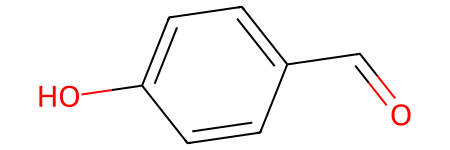

In [7]:
# 解析 SMILE 字符串
smile = "C1=CC(=CC=C1C=O)O"
graph, vertex_feat, edges_idx, *_ = decode_smile_into_graph(smile)
print("分子图节点特征：", vertex_feat)
print("分子图边特征：", edges_idx)
graph

下面的函数 `build_leffingwell_molecules_graph()` 从路径中读取 LeffingWell 分子数据，并**将每个分子解析为图数据**
* 为了简单考虑，在下面的演示中，我们将关注分子的 `pungent` 标签属性，如果一个**分子所展现出的性质具有刺鼻的特征**，其对应的 `pungent` 标签就为 1
* **因此，这里展示的全图分类任务是一个二分类任务**

In [7]:
def build_leffingwell_molecules_graph(path : str, behavier_name : str="pungent"):
    molecules = pd.read_csv(os.path.join(path,"molecules.csv"), index_col=0)
    behavier = pd.read_csv(os.path.join(path,"behavier.csv"), index_col=0)

    smiles = molecules['IsomericSMILES']

    # 存储每个分子的图信息
    graphs, labels = [], []

    # 依次获得分子的 SMILES 字符串
    for cid, smile in smiles.items():
        # 将 SMILE 解析为分子图
        graph, vertex_feat, edges_idx, neighbors_idx, \
        connected_edges_idx, valid_lens = ch8.decode_smile_into_graph(smile)
        
        # 从 edges_idx 中解绑边连接关系和边特征
        edges_feat = [edge[-1] for edge in edges_idx]
        edges_idx = [(edge[0], edge[1]) for edge in edges_idx]

        # 组装分子图信息
        graph_info = {
            "cid": cid,
            "graph": graph,
            "vertex_feat": vertex_feat,
            "edges_idx": edges_idx,
            "edges_feat": edges_feat,
            "neighbors_idx": neighbors_idx,
            "connected_edges_idx": connected_edges_idx,
            "valid_lens": valid_lens
        }
        
        # 添加到分子图列表
        graphs.append(graph_info)
        labels.append(behavier.loc[cid, behavier_name])
    
    return graphs, labels

In [8]:
path = "../source/data/graph/leffingwell/"
molecule_graphs, labels = build_leffingwell_molecules_graph(path,behavier_name="pungent")

In [9]:
# 生成子图数据迭代器
batch_size = 64
graph_loader = ch8.GraphDataLoader(molecule_graphs, labels, batch_size=batch_size, shuffle=False,
                                   removed_keys=("graph", "cid"))
graph_dataset = graph_loader.create_dataset()
# 打印查看子图数据的形状
for i, (graph_batch,labels_batch) in enumerate(graph_dataset.take(2)):
    for key in graph_batch.keys():
        print("第 %d 个批量 %-20s 的形状："%(i+1,key),graph_batch[key].shape)
    print("第 %d 个批量 %-20s 的形状："%(i+1,"labels"),labels_batch.shape)
    print("="*60)

第 1 个批量 vertex_feat          的形状： (64, 24, 1)
第 1 个批量 edges_feat           的形状： (64, 46, 1)
第 1 个批量 edges_idx            的形状： (64, 46, 2)
第 1 个批量 neighbors_idx        的形状： (64, 24, 4)
第 1 个批量 connected_edges_idx  的形状： (64, 24, 4)
第 1 个批量 valid_lens           的形状： (64, 24)
第 1 个批量 valid_nodes          的形状： (64,)
第 1 个批量 valid_edges          的形状： (64,)
第 1 个批量 labels               的形状： (64,)
第 2 个批量 vertex_feat          的形状： (64, 18, 1)
第 2 个批量 edges_feat           的形状： (64, 34, 1)
第 2 个批量 edges_idx            的形状： (64, 34, 2)
第 2 个批量 neighbors_idx        的形状： (64, 18, 4)
第 2 个批量 connected_edges_idx  的形状： (64, 18, 4)
第 2 个批量 valid_lens           的形状： (64, 18)
第 2 个批量 valid_nodes          的形状： (64,)
第 2 个批量 valid_edges          的形状： (64,)
第 2 个批量 labels               的形状： (64,)


最后，我们将加载 `LeffingWell` 数据、解析分子数据、创建图数据和数据迭代器的逻辑包装为 `load_leffingwell_molecules_data()`，并**将数据集切分为训练集和验证集**

In [62]:
def load_leffingwell_molecules_data(path : str, behavier_name : str="pungent", test_size : float=0.2, batch_size : int=64, seed : int=42):
    from sklearn.model_selection import train_test_split

    # 读取分子图数据
    graphs, labels = build_leffingwell_molecules_graph(path, behavier_name=behavier_name)

    # 切分训练集和测试集
    train_graphs, valid_graphs, train_labels, valid_labels = train_test_split(graphs, labels, test_size=test_size, random_state=seed)

    # 创建 GraphDataLoader
    removed_keys = ("graph", "cid")
    train_graphs = ch8.GraphDataLoader(train_graphs, train_labels, batch_size, shuffle=False, removed_keys=removed_keys)
    valid_graphs = ch8.GraphDataLoader(valid_graphs, valid_labels, batch_size, shuffle=False, removed_keys=removed_keys)

    return train_graphs, valid_graphs

**(2) 定义全图分类模型**

接下来我们定义用于分子分类的全图分类模型 `MoleculeClassifier`，核心的计算逻辑包括：
* 现在数据中节点特征、边特征都是表示类型的整数，可以**对其使用 `One-Hot` 编码变换为 0-1 向量**
  * 或者**等价地直接使用嵌入层，将节点特征、边特征分别嵌入为稠密向量**
* **初始时刻，图数据中缺少全图特征 `global_feat`**，我们可以**用节点特征的均值做初始化**
  * **或者使用全零向量**做初始化，让全局特征在 GN Block 中进行提取和学习
* 模型经过 `num_layers` 个 GN Block 提取图特征
* 最后将全图特征 **`global_feat` 作为下游全图分类器模型的输入特征**

In [11]:
class MoleculeClassifier(tf.keras.Model):
    def __init__(self, num_hiddens : int, num_classes : int, num_layers : int=1, dropout : float=0.25,
                 edge_mp : bool=True, node_mp : bool=True, global_mp : bool=True, **kwargs):
        super(MoleculeClassifier, self).__init__(**kwargs)
        # 结点特征和边特征的嵌入层
        self.num_hiddens = num_hiddens
        self.vertex_embed = tf.keras.layers.Embedding(input_dim=4, output_dim=num_hiddens)
        self.edge_embed = tf.keras.layers.Embedding(input_dim=4, output_dim=num_hiddens)

        # GN Block 层
        self.gn_blocks = [
            ch8.GNBlock(edge_num_hiddens=num_hiddens,node_num_hiddens=num_hiddens,
                        global_num_hiddens=num_hiddens,dropout=dropout,
                        node_mp=node_mp,edge_mp=edge_mp,global_mp=global_mp) for _ in range(num_layers)]
        
        # 下游任务分类器
        activate = "sigmoid" if num_classes == 1 else "softmax"
        self.classifier = tf.keras.models.Sequential([
            tf.keras.layers.Dropout(dropout),
            tf.keras.layers.Dense(num_classes, activation=activate)
        ])

    def call(self, graph, **kwargs):
        # 对节点特征和边特征进行嵌入，注意要去掉多余的维度
        # (num_graph, num_nodes or num_edges, 1) -> (num_graph, num_nodes or num_edges, 1, num_hiddens)
        # tf.squuze 去掉多余维度，(num_graph, num_nodes or num_edges, num_hiddens)
        graph["vertex_feat"] = tf.squeeze(self.vertex_embed(graph["vertex_feat"]), axis=2)
        graph["edges_feat"] = tf.squeeze(self.edge_embed(graph["edges_feat"]), axis=2)

        # 用 valid_nodes, valide_edges 创建掩码，将无效节点特征和边特征置零
        num_nodes, num_edges = graph["vertex_feat"].shape[1], graph["edges_feat"].shape[1]
        mask_nodes = tf.sequence_mask(graph["valid_nodes"], maxlen=num_nodes, dtype=tf.float32) # (num_graph, num_nodes)
        mask_edges = tf.sequence_mask(graph["valid_edges"], maxlen=num_edges, dtype=tf.float32) # (num_graph, num_edges)
        # 扩展 mask 的维度，(num_graph, num_nodes or num_edges, 1)，便于广播
        graph["vertex_feat"] = graph["vertex_feat"] * tf.expand_dims(mask_nodes, axis=-1)
        graph["edges_feat"] = graph["edges_feat"] * tf.expand_dims(mask_edges, axis=-1)

        # 初始化全图特征 global_feat，形状 (num_graph, num_hiddens)
        graph["global_feat"] = tf.reduce_sum(graph["vertex_feat"], axis=1)
        valid_nodes = tf.cast(graph["valid_nodes"], dtype=tf.float32) # (num_graph,)
        graph["global_feat"] = graph["global_feat"] / tf.expand_dims(valid_nodes, axis=1) # 扩展维度，进行广播

        # 多层 GN Block 提取图特征
        for layer in self.gn_blocks:
            graph = layer(graph, **kwargs)

        # 下游任务分类器
        embed_vec = graph["global_feat"] # 代表全图特征的嵌入向量，形状 (num_graph, num_hiddens)
        probs = self.classifier(embed_vec, **kwargs) # (num_graph, num_classes)

        # 输出全图嵌入特征 embed_vec 和预测结果
        return embed_vec, probs

    # 模型的预测方法 predcit，实现从 GraphDataLoader 的批量预测
    def predict(self, graph_iter : ch8.GraphDataLoader, **kwargs):
        probs, embeds = [], []
        for graph, _ in graph_iter.create_dataset(shuffle=False):
            embed, prob = self(graph, training=False, **kwargs)
            probs.append(prob)
            embeds.append(embed)
        # 将多个批量的预测结果拼接起来
        return tf.concat(embeds, axis=0), tf.concat(probs, axis=0)

In [13]:
# 二分类问题，可以设置 num_classes = 2
model = MoleculeClassifier(num_hiddens=32, num_classes=2, num_layers=2, dropout=0.25)
embeds, probs = model(graph_batch, training=False)
embeds.shape, probs.shape

(TensorShape([64, 32]), TensorShape([64, 2]))

**(3) 定义训练和评估逻辑**

最后，我们定义模型训练和评估逻辑，该二分类模型我们**使用 AUC 或者作为评估指标**

In [14]:
def train_gnn_graph_task(model, train_graphs, valid_graphs, epochs : int=10, lr : float=0.05, verbose : int=1):
    # 定义损失函数和优化器
    from sklearn.metrics import roc_auc_score
    loss_func = tf.keras.losses.SparseCategoricalCrossentropy()
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

    # 展示训练过程
    animator = utils.Animator(xlabel="epoch", xlim=[1, epochs], fmts=(('-'), ('m--','g-.')),
                              legend=[("train loss"), ("train AUC", "valid AUC")], figsize=(7,3), ncols=2)

    for epoch in range(epochs):
        train_graphs.shuffle = True
        for graph_batch, labels_batch in train_graphs.create_dataset(shuffle=True):
            with tf.GradientTape() as tape:
                _, probs = model(graph_batch, training=True)
                loss = loss_func(labels_batch, probs)
            weights = model.trainable_variables
            grads = tape.gradient(loss, weights)
            optimizer.apply_gradients(zip(grads, weights))
        
        if epoch == 0 or (epoch + 1) % verbose == 0:
            # 评估模型，通过批量预测
            _, train_probs = model.predict(train_graphs)
            _, valid_probs = model.predict(valid_graphs)

            # 计算损失和准确率
            train_loss = loss_func(train_graphs.labels, train_probs).numpy()
            train_auc = roc_auc_score(train_graphs.labels, train_probs.numpy()[:, 1])
            valid_auc = roc_auc_score(valid_graphs.labels, valid_probs.numpy()[:, 1])
            # 更新图像
            animator.add(epoch + 1, (train_loss, ),ax=0)
            animator.add(epoch + 1, (train_auc, valid_auc),ax=1)
    
    return model

接下来，导入数据集，然后创建模型，开始训练

In [405]:
# 导入分子预测数据集
path = "../source/data/graph/leffingwell/"
train_graphs, valid_graphs = ch8.load_leffingwell_molecules_data(path, behavier_name="pungent", test_size=0.2, batch_size=256)

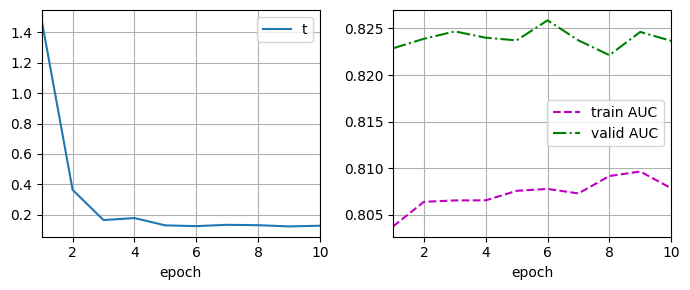

In [421]:
# 创建模型，开始训练
model_params = {
    "num_hiddens": 20, "num_classes": 2, "num_layers": 2, "dropout": 0.25,
    "edge_mp": True, "node_mp": True, "global_mp": True
} # 设置模型参数
model = ch8.MoleculeClassifier(**model_params)
model = ch8.train_gnn_graph_task(model, train_graphs, valid_graphs, epochs=10, lr=0.05, verbose=1)

我们接下来尝试**可视化模型的决策边界**，这需要**利用模型计算得到的每个分子全图嵌入特征 `embedding`，即 `global_feat`**
* 通常来说，这是一个**高维向量**，维度为 `global_num_hiddens`，**为了可视化决策边界**，我们需要**先对特征降维**
* 降维的方法有很多，例如 **PCA**，或者 **t-SNE**

下面的函数 `visualize_embedding_tSNE()` **通过 t-SNE 将图嵌入特征 `global_feat` 降维到二维，然后将降维后的特征空间和决策情况进行可视化**

In [415]:
def visualize_embedding_tSNE(embeds, probs, labels, perplexity : int=10, figsize=(6, 5)):
    from sklearn.manifold import TSNE
    from sklearn.preprocessing import MinMaxScaler
    from matplotlib.colors import LinearSegmentedColormap

    # 进行降维并归一化
    embeds_2d = TSNE(n_components=2, perplexity=perplexity).fit_transform(embeds)
    embeds_2d = MinMaxScaler().fit_transform(embeds_2d)

    # 可视化低维特征空间和决策情况
    fig = plt.figure(figsize=figsize)
    # 绘制内部颜色，创建 Normalize 对象实现自定义的颜色条
    cmap = LinearSegmentedColormap.from_list(
        "custom_cmap", [(0, "cadetblue"), (0.15, "grey"), (0.7, "salmon"), (1, "salmon")])

    scatter1 = plt.scatter(embeds_2d[:,0], embeds_2d[:,1], vmax=1,
                           c=probs, cmap=cmap, alpha=[0.6 if label == 1 else 0.1 for label in labels])
    for label in [0, 1]:
        idx = (labels == label) # 获取标签为 label 的索引
        edgecolors = "red" if label == 1 else "black" # 设置边缘颜色
        class_name = "pungent" if label == 1 else "non-pungent" # 设置类别名称
        linewidth = 0.5 if label == 1 else 0.1 # 设置边缘宽度
        # 绘制边缘颜色
        plt.scatter(embeds_2d[idx, 0], embeds_2d[idx, 1], 
                    c="none", edgecolors=edgecolors, linewidths=linewidth, label=class_name)
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.legend(loc="upper left")
    cbar = plt.colorbar(scatter1)

    return embeds_2d

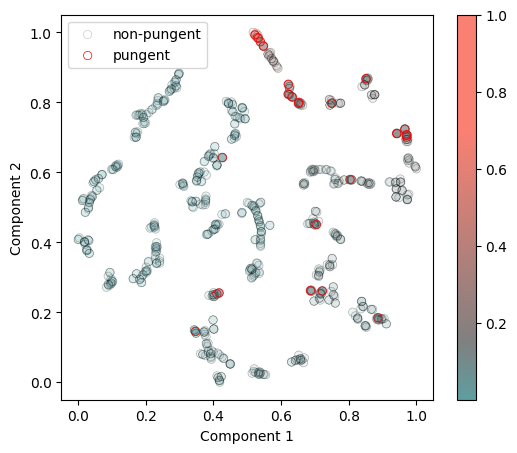

In [422]:
# 获得验证集上的模型推理结果，图嵌入特征 embeds 和预测概率 probs
embeds, probs = model.predict(valid_graphs)
embeds, probs = embeds.numpy(), probs.numpy()[:,1]
labels = np.array(valid_graphs.labels) # 获得验证集的标签
# 可视化低维特征空间
embeds_2d = ch8.visualize_embedding_tSNE(embeds, probs, labels, perplexity=8, figsize=(6, 5))

一个**完美的模型应该能够完全将两类样本（`pungent` 和 `non-pungent`）分隔开**
* 但由于我们**对特征空间做了压缩**，同时**模型也不是完美的分类器**
* 从二维特征空间中看到清晰的决策边界比较困难，但依然**能看到在空间中的某个部分，`pungent` 类的分子的全图特征形成的聚集趋势**

作为对比，我们创建另一个分子分类模型，但**关闭所有的消息传递路径，即设置 `edge_mp = node_mp = global_mp = True`**
* 由于关闭消息传递后，**`GNBlock` 计算过程中一些参数的计算不会被记录到梯度的追踪中**（因为最后模型的输出结果和它们的计算无关），此时 `Tensorflow` 会发出相关的警告提示，我们可以用 `logging` 关闭它

In [403]:
# 关闭 Tensorflow 的警告日志输出
import logging
logging.getLogger('tensorflow').disabled = True

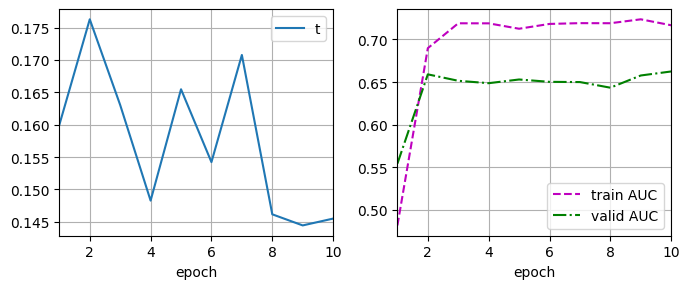

In [419]:
# 创建模型，开始训练
model_params = {
    "num_hiddens": 20, "num_classes": 2, "num_layers": 2, "dropout": 0.25,
    "edge_mp": False, "node_mp": False, "global_mp": False # 关闭消息传递
} # 设置模型参数
model = ch8.MoleculeClassifier(**model_params)
model = ch8.train_gnn_graph_task(model, train_graphs, valid_graphs, epochs=10, lr=0.05, verbose=1)

在**关闭了 GNN 的消息传递后，模型的性能出现了大幅下滑**，并且从下面决策空间可视化的结果可以看到，**关闭消息传递后，决策边界变得更加不清晰了，`pungent` 类分子特征的聚集现象也消失了**

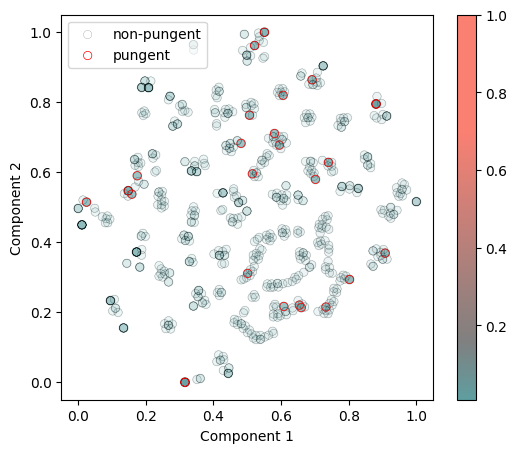

In [420]:
# 获得验证集上的模型推理结果，图嵌入特征 embeds 和预测概率 probs
embeds, probs = model.predict(valid_graphs)
embeds, probs = embeds.numpy(), probs.numpy()[:,1]
labels = np.array(valid_graphs.labels) # 获得验证集的标签
# 可视化低维特征空间
embeds_2d = ch8.visualize_embedding_tSNE(embeds, probs, labels, perplexity=8, figsize=(6, 5))

----

### **练习**

1. 下面的实验，我们来尝试一些其他的消息传递机制来定义 `GNBlock`
   1. 保持其他模块不变，**仿照 `GAT`，将 $\rho_{E\to V}$ 的聚合逻辑替换为注意力机制来实现**，你可以通过**继承本节的 `GNBlock`，然后仅需重写它的 `rho_edge_to_node()` 函数逻辑**，然后使用 `LeffingWell` 分子分类数据集，设置合适的超参数，创建模型进行训练，汇报模型性能
   2. 基于所学的知识，设计一个你喜欢的 `GNBlock` 实现
      1. 你可以选择重写部分计算逻辑，或者对 $\phi_e,\phi_v,\phi_u,\rho_{E\to V},\rho_{E\to U},\rho_{V\to U}$ 全部重写
      2. 测试所定义的模型

2. 尝试不同的 `edge_mp, node_mp, global_mp` 组合，观察不同组合下模型性能的变化，感受消息传递在 GNN 中的作用

----